## LSTF-linear
- https://today-1.tistory.com/60

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 200
pd.set_option("display.max_rows", 100)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm

In [3]:
class LTSF_Linear(nn.Module):
    def __init__(self, window_size, forecast_size, individual, feature_size):
        super(LTSF_Linear, self).__init__()
        self.window_size = window_size
        self.forecast_size = forecast_size
        self.individual = individual
        self.channels = feature_size
        
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Liner.append(torch.nn.Linear(self.window_size, self.forecast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forecast_size)
            
    def forward(self, x):
        # x: [Batch, Input length, feature size]
        if self.individual:
            output = torch.zeros([x.size(0), self.forecast_size, x.size(2)],
                                 dtype = x.dtype).to(x.device)
            for i in range(self.channels):
                output[:, :, i] = self.Linear[i](x[:, :, i])
            x = output
        else:
            x = self.Linear(x.permute(0, 2, 1)).permute(0, 2, 1)
        return x # [Batch, Output length, feature size]        

In [4]:
batch_size = 32 
in_seq_len = 3 
pred_len = 2
channel = 5
X = torch.randn(batch_size, in_seq_len, channel)
X.shape

torch.Size([32, 3, 5])

In [5]:
one_linear = nn.Linear(
    in_features=in_seq_len,
    out_features=pred_len
)
one_linear

Linear(in_features=3, out_features=2, bias=True)

In [6]:
output = torch.zeros(batch_size, pred_len, channel)
output.shape

torch.Size([32, 2, 5])

In [7]:
# 한 채널만 예시로
output[:,:,0]=one_linear(X[:,:,0])

In [8]:
print(output[:,0,0])
print(output[:,1,0])

tensor([-0.0571,  0.8823,  0.8055, -0.5190,  0.8661, -0.4205, -0.3200, -0.0144,
        -0.6285, -0.2218, -0.3365, -0.6867,  0.1758, -1.3017, -0.1676,  0.1785,
        -0.2600,  0.6459,  0.0721, -0.0899, -0.0042,  1.0983,  0.3661,  0.8148,
         0.5063, -0.1642,  0.0844, -0.0876,  0.2977,  0.1380,  0.3722,  0.1994],
       grad_fn=<SelectBackward0>)
tensor([ 0.0432,  0.5024,  0.1522, -0.2923,  0.5946,  0.0102,  0.0715, -0.0838,
        -0.1525, -0.0707, -0.0290, -0.1910,  0.2703, -0.2671, -0.0426, -0.0227,
        -0.0082,  0.3712,  0.1396, -0.0271,  0.0362,  0.3784,  0.3668,  0.6464,
         0.3604,  0.0680,  0.0607, -0.3158,  0.1252,  0.1535,  0.5722,  0.2297],
       grad_fn=<SelectBackward0>)


In [9]:
output = one_linear(X.permute(0,2,1)).permute(0,2,1)
output.shape

torch.Size([32, 2, 5])

### NLinear

In [10]:
class LTSF_NLinear(nn.Module):
    def __init__(
        self,
        window_size,
        forecast_size, 
        individual,
        feature_size
    ):
        super(LTSF_NLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forecast_size
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(torch.nn.Linear(self.window_size, self.forcast_size))
        else:
            self.Linear = torch.nn.Linear(self.window_size, self.forcast_size)
            
    def forward(self, x):
        seq_last = x[: -1:, :].detach() # 기존 텐서를 복사하는 방법
        x = x - seq_last
        if self.individual:
            output = torch.zeros([x.size(0), self.forcast_size, x.size(2)],
                                 dtype=x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])
            x = output
        else:
            x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x

### DLinear

In [11]:
class moving_avg(nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(
            kernel_size=kernel_size,
            stride=stride,
            padding = 0
        )
        
    def forward(self, x):
        # [BATCH SIZE, SEQ_LEN, CHANNEL]
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1) # 패딩을 위한 것
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x # [BATCH SIZE, SEQ_LEN, CHANNEL]

In [12]:
class series_decomp(nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual 

In [13]:
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forecast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forecast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(
                    torch.nn.Linear(
                        self.window_size, 
                        self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        trend_init, seasonal_init = self.decompsition(x)
        # seasonal_init: [Batch, Input length, Channel]
        # trend_init: [Batch, Input length, Channel]
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

---

In [14]:
#Library Imports
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [15]:
train=pd.read_csv('../data/elec/train.csv',encoding='cp949')
test=pd.read_csv('../data/elec/test.csv', encoding='cp949')
submission=pd.read_csv('../data/elec/sample_submission.csv')


In [16]:
train.columns

Index(['num', 'date_time', '전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)',
       '강수량(mm)', '일조(hr)', '비전기냉방설비운영', '태양광보유'],
      dtype='object')

In [17]:
train_5 = train.loc[train['num']==5]
train_5.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
8160,5,2020-06-01 00,3063.744,18.3,2.5,94.0,0.0,0.0,1.0,0.0
8161,5,2020-06-01 01,3147.120,18.8,2.3,89.0,0.0,0.0,1.0,0.0
8162,5,2020-06-01 02,3098.736,19.0,3.2,86.0,0.0,0.0,1.0,0.0
8163,5,2020-06-01 03,3047.760,19.0,4.1,85.0,0.0,0.0,1.0,0.0
8164,5,2020-06-01 04,3111.696,18.9,3.9,87.0,0.0,0.0,1.0,0.0


In [18]:
train_5['date_time'] = pd.to_datetime(train_5.date_time)

<Axes: xlabel='date_time'>

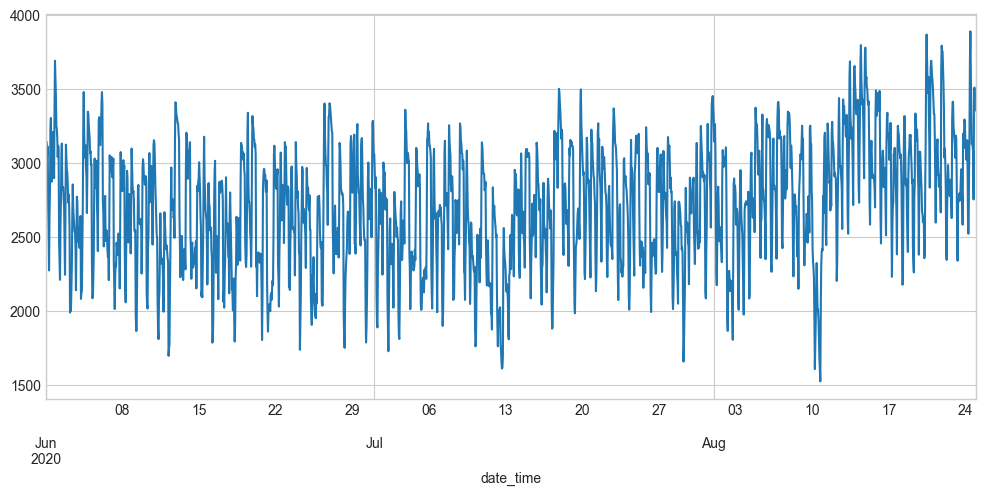

In [19]:
train_5.set_index('date_time')["전력사용량(kWh)"].plot(figsize = (12, 5))

In [20]:
def standardization(train_df, test_df, not_col, target):
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_list = []
    std_list = []
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        mean_list.append(mean)
        std_list.append(std)
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
    return train_df_, test_df_, mean_list[col.index(target)], std_list[col.index(target)]

In [21]:
def time_slide_df(df, window_size, forecast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0]-window_size-forecast_size+1):
        x = df_.loc[idx:idx+window_size-1, target].values.reshape(window_size, 1)
        y = df_.loc[idx+window_size:idx+window_size+forecast_size-1, target].values
        date_ = df_.loc[idx+window_size:idx+window_size+forecast_size-1, date].values
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

In [22]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [23]:
### Univariable ###
### 데이터 셋 생성 ###
window_size = 72
forecast_size= 24
batch_size = 32
targets = '전력사용량(kWh)'
date = 'date_time'

In [24]:
train_5 = train_5[train_5.columns[1:-2]].reset_index(drop=True)

In [25]:
train_5

,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr)
0,2020-06-01 00:00:00,3063.744,18.3,2.5,94.0,0.0,0.0
1,2020-06-01 01:00:00,3147.120,18.8,2.3,89.0,0.0,0.0
2,2020-06-01 02:00:00,3098.736,19.0,3.2,86.0,0.0,0.0
3,2020-06-01 03:00:00,3047.760,19.0,4.1,85.0,0.0,0.0
4,2020-06-01 04:00:00,3111.696,18.9,3.9,87.0,0.0,0.0
...,...,...,...,...,...,...,...
2035,2020-08-24 19:00:00,3439.152,27.9,1.7,83.0,0.0,0.6
2036,2020-08-24 20:00:00,3510.432,27.4,1.4,83.0,0.0,0.0
2037,2020-08-24 21:00:00,3458.160,27.1,1.4,86.0,0.0,0.0
2038,2020-08-24 22:00:00,3421.008,26.9,0.0,84.0,0.0,0.0


In [26]:
train_df_fe, test_df_fe, mean_, std_ = standardization(train_5, train_5, 'date_time', targets)

In [27]:
train_df_fe

,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr)
0,2020-06-01 00:00:00,0.858938,-1.721194,-0.359481,0.928674,-0.187485,-0.609422
1,2020-06-01 01:00:00,1.064000,-1.559529,-0.462486,0.568339,-0.187485,-0.609422
2,2020-06-01 02:00:00,0.945000,-1.494863,0.001035,0.352139,-0.187485,-0.609422
3,2020-06-01 03:00:00,0.819625,-1.494863,0.464556,0.280072,-0.187485,-0.609422
4,2020-06-01 04:00:00,0.976875,-1.527196,0.361551,0.424206,-0.187485,-0.609422
...,...,...,...,...,...,...,...
2035,2020-08-24 19:00:00,1.782250,1.382775,-0.771500,0.135938,-0.187485,0.922267
2036,2020-08-24 20:00:00,1.957562,1.221110,-0.926007,0.135938,-0.187485,-0.609422
2037,2020-08-24 21:00:00,1.829000,1.124111,-0.926007,0.352139,-0.187485,-0.609422
2038,2020-08-24 22:00:00,1.737625,1.059445,-1.647039,0.208005,-0.187485,-0.609422


In [28]:
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, targets)

In [29]:
train_x.shape

(1945, 72, 1)

In [30]:
train_x[0].shape

(72, 1)

In [31]:
train_y.shape

(1945, 24)

In [32]:
train_ds = Data(train_x[:1000], train_y[:1000])
valid_ds = Data(train_x[1000:], train_y[1000:])

In [33]:
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True,)
valid_dl = DataLoader(valid_ds, batch_size = train_x[1000:].shape[0], shuffle=False)

In [34]:
### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 50
lr = 0.001

In [35]:
DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forecast_size=forecast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )

In [36]:

DLinear_model

LTSF_DLinear(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Trend): Linear(in_features=72, out_features=24, bias=True)
  (Linear_Seasonal): Linear(in_features=72, out_features=24, bias=True)
)

In [37]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

In [38]:
for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    train_loss_list.append(np.mean(loss_list))
    
    
    DLinear_model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)
            
    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, Model Save".format(valid_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}".format(
        epoch, np.mean(loss_list), valid_loss))


  0%|          | 0/50 [00:00<?, ?it/s]

valid_loss=0.718, Model Save
epoch = 1, train_loss : 0.732, valid_loss : 0.718
valid_loss=0.655, Model Save
epoch = 2, train_loss : 0.558, valid_loss : 0.655
valid_loss=0.639, Model Save
epoch = 3, train_loss : 0.506, valid_loss : 0.639
epoch = 4, train_loss : 0.481, valid_loss : 0.645
epoch = 5, train_loss : 0.464, valid_loss : 0.666
epoch = 6, train_loss : 0.453, valid_loss : 0.655
epoch = 7, train_loss : 0.449, valid_loss : 0.694
epoch = 8, train_loss : 0.442, valid_loss : 0.681
epoch = 9, train_loss : 0.442, valid_loss : 0.713
epoch = 10, train_loss : 0.439, valid_loss : 0.715
epoch = 11, train_loss : 0.435, valid_loss : 0.718
epoch = 12, train_loss : 0.434, valid_loss : 0.714
epoch = 13, train_loss : 0.429, valid_loss : 0.720
epoch = 14, train_loss : 0.426, valid_loss : 0.747
epoch = 15, train_loss : 0.426, valid_loss : 0.748
epoch = 16, train_loss : 0.425, valid_loss : 0.768
epoch = 17, train_loss : 0.421, valid_loss : 0.734
epoch = 18, train_loss : 0.420, valid_loss : 0.752
epoc

In [39]:
weights_list = {}
weights_list['trend'] = DLinear_model.Linear_Trend.weight.detach().numpy()
weights_list['seasonal'] = DLinear_model.Linear_Seasonal.weight.detach().numpy()

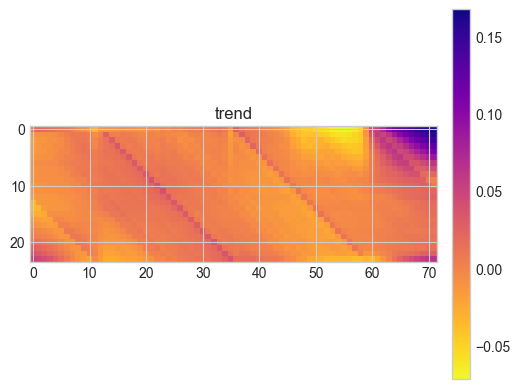

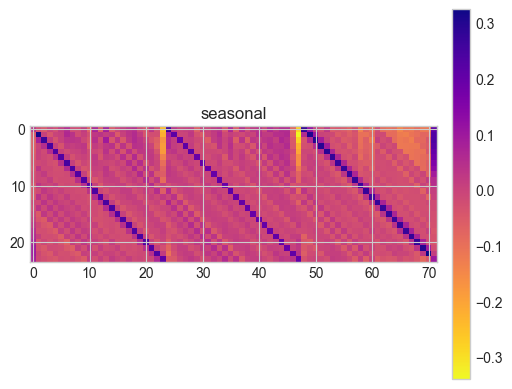

In [40]:
for name, w in weights_list.items():    
    fig, ax = plt.subplots()    
    plt.title(name)
    im = ax.imshow(w, cmap='plasma_r',)
    fig.colorbar(im, pad=0.03)
    plt.show()